Original Energy-weighted mean log₂(w²): -4.0866
Corresponding mean log₂(|w|): -2.0433
Floored log₂(|w|): -3
Final scale: 2^(--3) = 8.000000
After Scaling: Energy-weighted mean log₂(w²): 1.9134
After Scaling: mean log₂(|w|): 0.9567


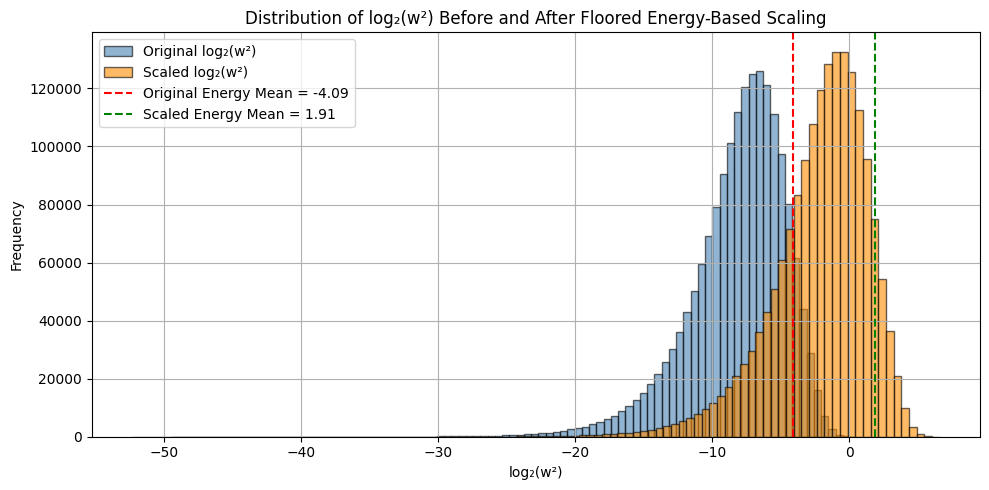

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model

# Step 1: Load GPT-2 model and extract attention weights
model = GPT2Model.from_pretrained("gpt2")
attn_weights = model.h[1].attn.c_attn.weight.detach().cpu().numpy().flatten()

# Step 2: Compute log2 energy of original weights
epsilon = 1e-8
abs_weights = np.abs(attn_weights) + epsilon
log2_abs = np.log2(abs_weights)
log2_energy = 2 * log2_abs  # log2(w²)
energy = attn_weights ** 2

# Step 3: Compute original energy-weighted mean of log2(w²)
mean_log2_energy = np.sum(log2_energy * energy) / np.sum(energy)
mean_log2_abs = mean_log2_energy / 2

# Floor the mean log2(|w|) to align with power-of-2 scaling
floored_log2 = int(np.floor(mean_log2_abs))
scale = 2 ** (-floored_log2)

print(f"Original Energy-weighted mean log₂(w²): {mean_log2_energy:.4f}")
print(f"Corresponding mean log₂(|w|): {mean_log2_abs:.4f}")
print(f"Floored log₂(|w|): {floored_log2}")
print(f"Final scale: 2^(-{floored_log2}) = {scale:.6f}")

# Step 4: Apply scaling
scaled_weights = attn_weights * scale
abs_scaled = np.abs(scaled_weights) + epsilon
log2_abs_scaled = np.log2(abs_scaled)
log2_energy_scaled = 2 * log2_abs_scaled
energy_scaled = scaled_weights ** 2

# Step 5: Compute energy-weighted mean of scaled log2(w²)
mean_log2_energy_scaled = np.sum(log2_energy_scaled * energy_scaled) / np.sum(energy_scaled)

print(f"After Scaling: Energy-weighted mean log₂(w²): {mean_log2_energy_scaled:.4f}")
print(f"After Scaling: mean log₂(|w|): {mean_log2_energy_scaled / 2:.4f}")

# Step 6: Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(log2_energy, bins=100, alpha=0.6, label="Original log₂(w²)", color="steelblue", edgecolor='black')
plt.hist(log2_energy_scaled, bins=100, alpha=0.6, label="Scaled log₂(w²)", color="darkorange", edgecolor='black')
plt.axvline(x=mean_log2_energy, color='red', linestyle='--', label=f"Original Energy Mean = {mean_log2_energy:.2f}")
plt.axvline(x=mean_log2_energy_scaled, color='green', linestyle='--', label=f"Scaled Energy Mean = {mean_log2_energy_scaled:.2f}")
plt.title("Distribution of log₂(w²) Before and After Floored Energy-Based Scaling")
plt.xlabel("log₂(w²)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Median log₂(|w|): -3.6104
Floored log₂(|w|): 3
Final scale: 2^(-3) = 0.125000


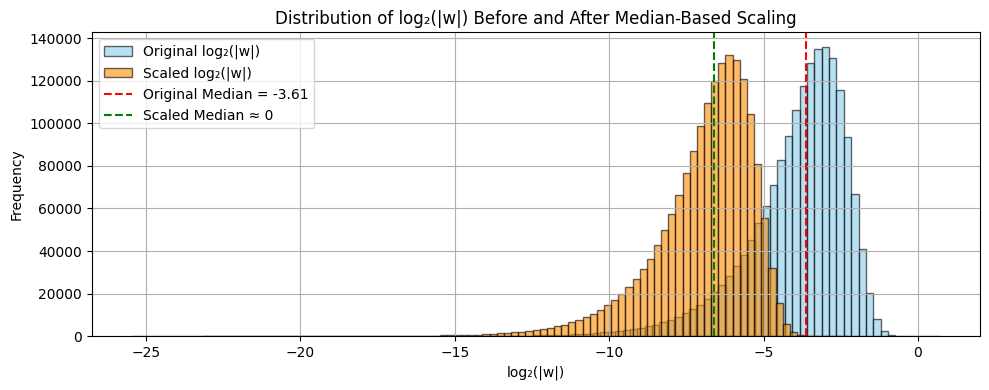

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model

# Step 1: Load GPT-2 model and extract attention weights
model = GPT2Model.from_pretrained("gpt2")
attn_weights = model.h[6].attn.c_attn.weight.detach().cpu().numpy().flatten()

# Step 2: Compute log2(|w|) and median
epsilon = 1e-8
abs_weights = np.abs(attn_weights) + epsilon
log2_abs = np.log2(abs_weights)
median_log2_abs = np.median(log2_abs)

# Floor to nearest power-of-2 scaling
floored_log2 = int(np.floor(np.abs(median_log2_abs)))
scale = 2 ** (floored_log2)

print(f"Median log₂(|w|): {median_log2_abs:.4f}")
print(f"Floored log₂(|w|): {floored_log2}")
print(f"Final scale: 2^(-{floored_log2}) = {scale:.6f}")

# Step 3: Apply scaling
scaled_weights = attn_weights * scale
log2_abs_scaled = np.log2(np.abs(scaled_weights) + epsilon)

# Step 4: Plot
plt.figure(figsize=(10, 4))
plt.hist(log2_abs, bins=100, alpha=0.6, label="Original log₂(|w|)", color="skyblue", edgecolor='black')
plt.hist(log2_abs_scaled, bins=100, alpha=0.6, label="Scaled log₂(|w|)", color="darkorange", edgecolor='black')
plt.axvline(x=median_log2_abs, color='red', linestyle='--', label=f"Original Median = {median_log2_abs:.2f}")
plt.axvline(x=median_log2_abs - floored_log2, color='green', linestyle='--', label=f"Scaled Median ≈ 0")
plt.title("Distribution of log₂(|w|) Before and After Median-Based Scaling")
plt.xlabel("log₂(|w|)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import torch
from qtorch_plus.quant import posit_quantize

# Get original attention weights
attn_weights = model.h[6].attn.c_attn.weight.detach().cpu().to(dtype=torch.float32)

# Compute signal power once
epsilon = 1e-8
signal_power = torch.sum(attn_weights ** 2)

# Sweep scale from 1 to 15
for scale in range(1, 5):
    quantized_weights = posit_quantize(attn_weights, nsize=4, es=0, scale=2**scale)
    noise_power = torch.sum((attn_weights - quantized_weights) ** 2) + epsilon
    sqnr = 10 * torch.log10(signal_power / noise_power)
    print(f"SQNR (nsize=4, es=0, scale={2**scale}): {sqnr.item():.2f} dB")


SQNR (nsize=4, es=0, scale=2): 5.55 dB
SQNR (nsize=4, es=0, scale=4): 13.14 dB
SQNR (nsize=4, es=0, scale=8): 16.30 dB
SQNR (nsize=4, es=0, scale=16): 13.54 dB


In [101]:
# INT4 quantization: symmetric, uniform quantizer
def int4_quantize_asymmetric(tensor):
    int4_min, int4_max = -8, 7  # signed INT4 range
    x_min, x_max = tensor.min(), tensor.max()

    # Calculate scale and zero-point
    scale = (x_max - x_min) / (int4_max - int4_min)
    zero_point = torch.round(-x_min / scale) + int4_min

    print(f"INT4 Asymmetric -> scale: {scale:.6f}, zero_point: {zero_point.item()}")

    # Quantize + clip
    quantized = torch.round(tensor / scale + zero_point)
    quantized = torch.clamp(quantized, int4_min, int4_max)

    # Dequantize
    dequantized = (quantized - zero_point) * scale
    return dequantized



# Apply INT4 quantization
quantized_int4 = int4_quantize_asymmetric(attn_weights)

# Compute SQNR for INT4
noise_power_int4 = torch.sum((attn_weights - quantized_int4) ** 2) + epsilon
sqnr_int4 = 10 * torch.log10(signal_power / noise_power_int4)

print(f"SQNR (int4 symmetric): {sqnr_int4.item():.2f} dB")


INT4 Asymmetric -> scale: 0.154357, zero_point: -1.0
SQNR (int4 symmetric): 10.10 dB


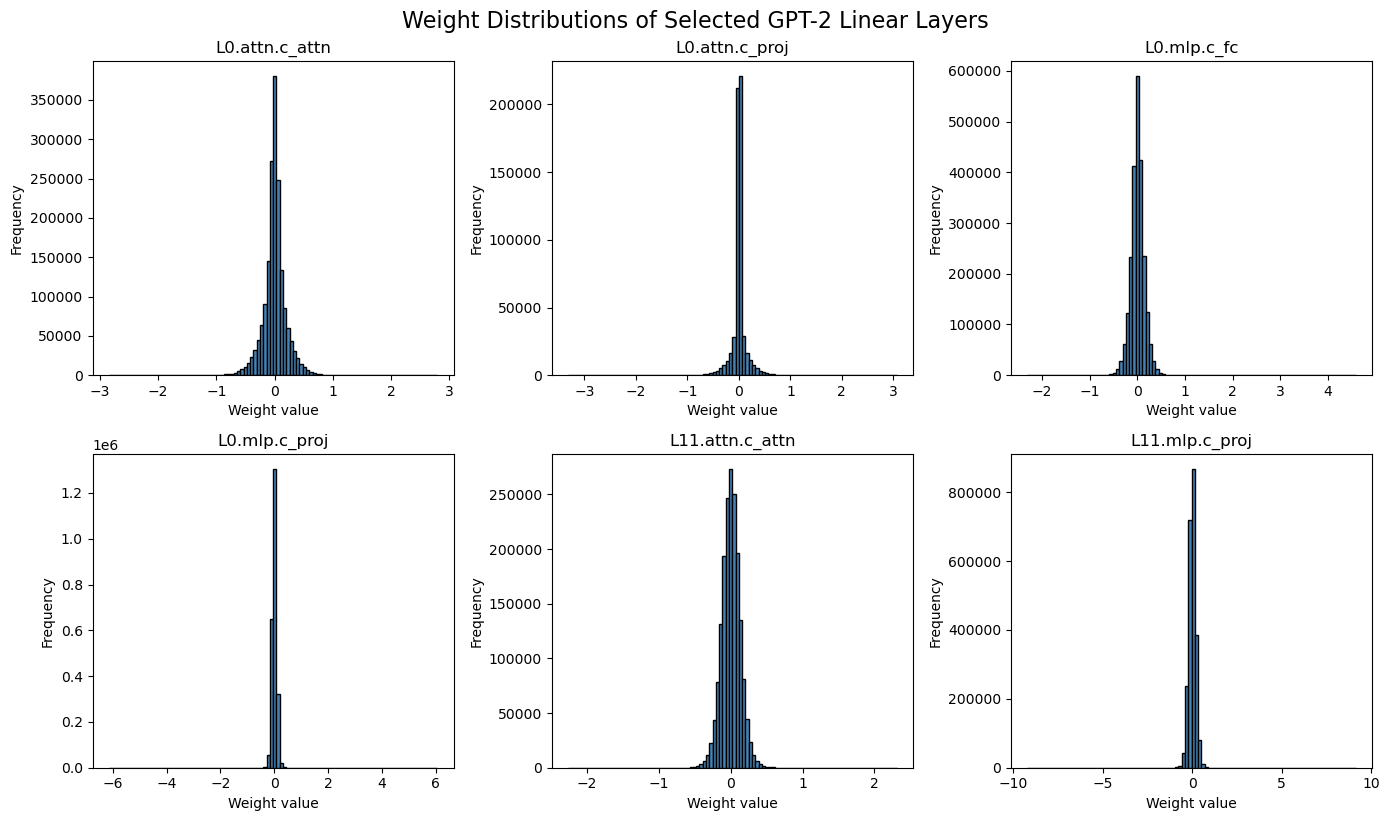

In [102]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model

# Load model
model = GPT2Model.from_pretrained("gpt2")

# List of specific linear layers to visualize
layers_to_plot = [
    ("L0.attn.c_attn", model.h[0].attn.c_attn.weight),
    ("L0.attn.c_proj", model.h[0].attn.c_proj.weight),
    ("L0.mlp.c_fc",    model.h[0].mlp.c_fc.weight),
    ("L0.mlp.c_proj",  model.h[0].mlp.c_proj.weight),
    ("L11.attn.c_attn", model.h[11].attn.c_attn.weight),
    ("L11.mlp.c_proj", model.h[11].mlp.c_proj.weight),
]

# Plot
plt.figure(figsize=(14, 8))

for i, (name, weight_param) in enumerate(layers_to_plot):
    weights = weight_param.detach().cpu().numpy().flatten()

    plt.subplot(2, 3, i + 1)
    plt.hist(weights, bins=100, color='steelblue', edgecolor='black')
    plt.title(name)
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Weight Distributions of Selected GPT-2 Linear Layers", fontsize=16, y=1.02)
plt.show()


/home/yimin/miniconda3/envs/posit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-21 14:02:57.794173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 14:02:57.801497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 14:02:57.810106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 14:02:

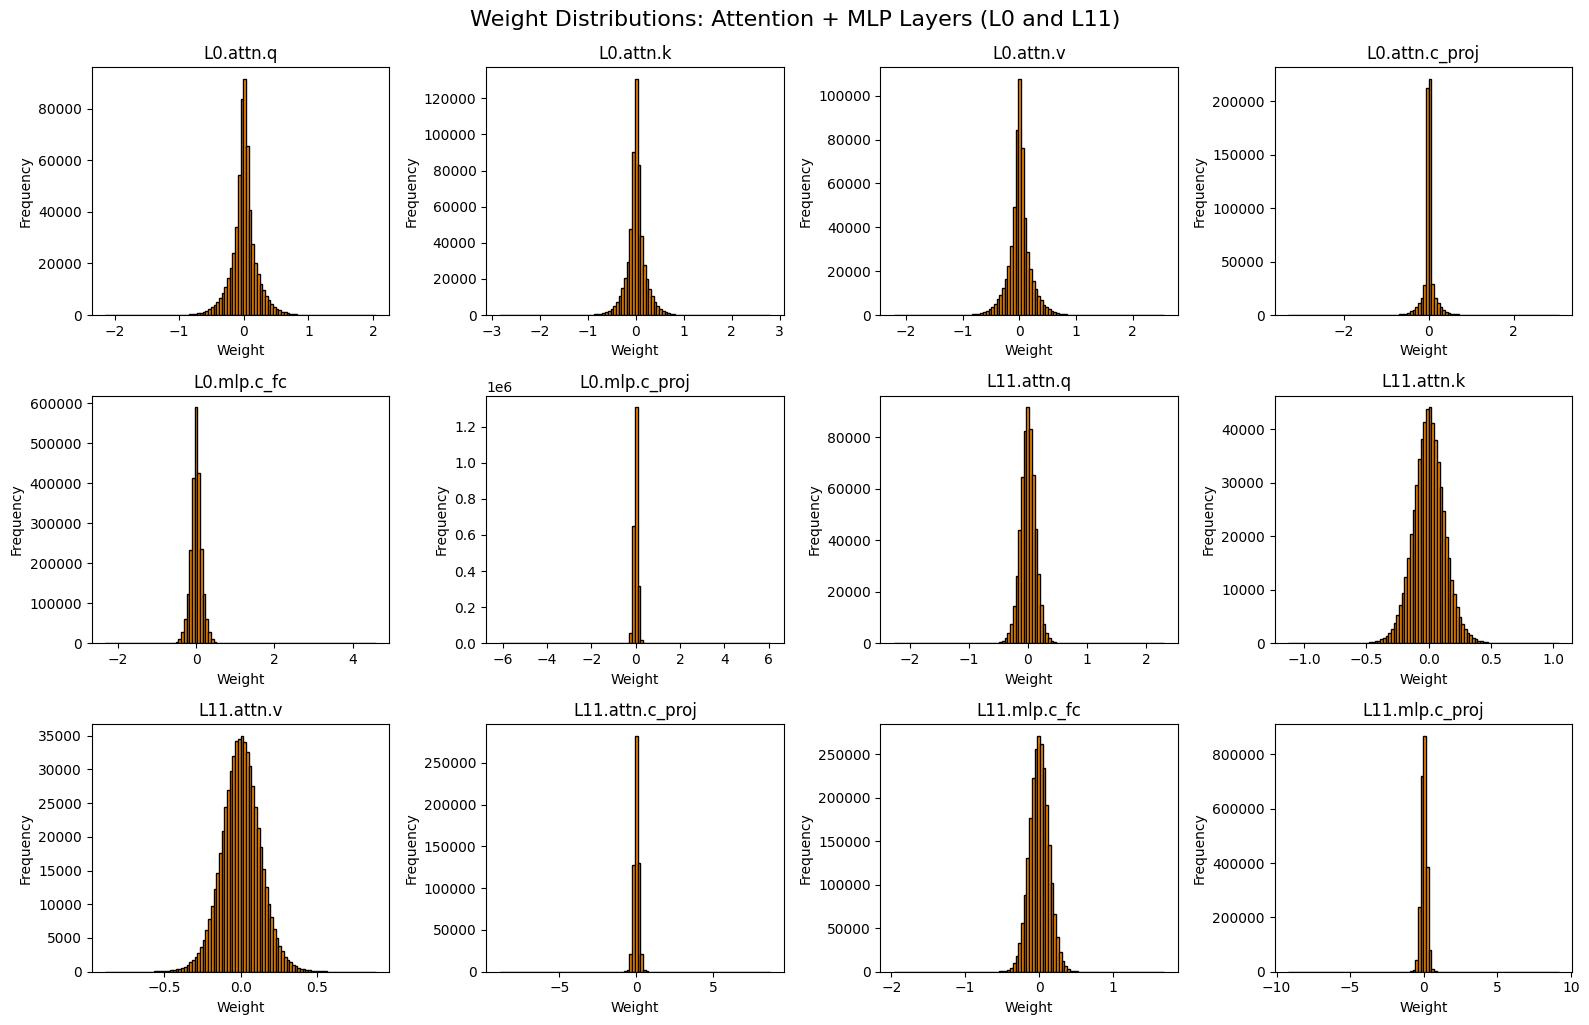

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Model

# Load GPT-2 model
model = GPT2Model.from_pretrained("gpt2")
hidden_size = model.config.hidden_size

# Choose a layer (e.g., layer 0 and layer 11)
blocks = [model.h[0], model.h[11]]  # early and late layer
layer_ids = [0, 11]

layers_to_plot = []

for block, lid in zip(blocks, layer_ids):
    # Split c_attn into Q, K, V
    attn_w = block.attn.c_attn.weight.detach().cpu()
    qkv = torch.chunk(attn_w, 3, dim=0)
    layers_to_plot += [
        (f"L{lid}.attn.q", qkv[0]),
        (f"L{lid}.attn.k", qkv[1]),
        (f"L{lid}.attn.v", qkv[2]),
        (f"L{lid}.attn.c_proj", block.attn.c_proj.weight.detach().cpu()),
        (f"L{lid}.mlp.c_fc", block.mlp.c_fc.weight.detach().cpu()),
        (f"L{lid}.mlp.c_proj", block.mlp.c_proj.weight.detach().cpu())
    ]

# Plot histograms
plt.figure(figsize=(16, 10))
for i, (name, weight_tensor) in enumerate(layers_to_plot):
    weights = weight_tensor.numpy().flatten()
    plt.subplot(3, 4, i + 1)
    plt.hist(weights, bins=100, color='darkorange', edgecolor='black')
    plt.title(name)
    plt.xlabel("Weight")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Weight Distributions: Attention + MLP Layers (L0 and L11)", fontsize=16, y=1.02)
plt.show()
